In [5]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
NUM_FEATURES = 100
SAMPLE_SIZE = 200
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
DATASET_DIR = os.path.join(path, 'Aerial_Landscapes')

datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    zoom_range=[0.8, 1.2]
)

def extract_sift_features(img, num_features):
    sift = cv2.SIFT_create(nfeatures=num_features)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(num_features * 128)
    descriptors = descriptors[:num_features] if len(descriptors) > num_features else np.pad(
        descriptors, ((0, num_features - len(descriptors)), (0, 0)), 'constant'
    )
    return descriptors.flatten()

In [ ]:
def load_and_preprocess_data(dataset_path, sample_size=200):
    X_sift, y = [], []
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print(f"Found {len(classes)} classes: {', '.join(classes)}")
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > sample_size:
            image_files = np.random.choice(image_files, sample_size, replace=False)
        
        print(f"Processing class {class_name}: {len(image_files)} images")
        
        for img_file in tqdm(image_files, desc=f"Class {class_name}"):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read {img_path}")
                continue
            img = cv2.resize(img, (256, 256))
            features = extract_sift_features(img, NUM_FEATURES)
            X_sift.append(features.flatten())
            y.append(class_name)

            for batch in datagen.flow(np.expand_dims(img, 0), batch_size=1):
                aug_img = batch[0].astype(np.uint8)
                features = extract_sift_features(aug_img, NUM_FEATURES)
                X_sift.append(features.flatten())
                y.append(class_name)
                break
    
    return np.array(X_sift), np.array(y)

print("Loading and preprocessing data...")
X, y = load_and_preprocess_data(DATASET_DIR, SAMPLE_SIZE)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Loading and preprocessing data...
Found 15 classes: Agriculture, Airport, Beach, City, Desert, Forest, Grassland, Highway, Lake, Mountain, Parking, Port, Railway, Residential, River
Processing class Agriculture: 200 images


Class Agriculture: 100%|██████████| 200/200 [00:15<00:00, 13.05it/s]


Processing class Airport: 200 images


Class Airport: 100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


Processing class Beach: 200 images


Class Beach: 100%|██████████| 200/200 [00:13<00:00, 14.45it/s]


Processing class City: 200 images


Class City: 100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


Processing class Desert: 200 images


Class Desert: 100%|██████████| 200/200 [00:13<00:00, 14.54it/s]


Processing class Forest: 200 images


Class Forest: 100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Processing class Grassland: 200 images


Class Grassland: 100%|██████████| 200/200 [00:13<00:00, 14.98it/s]


Processing class Highway: 200 images


Class Highway: 100%|██████████| 200/200 [00:14<00:00, 13.37it/s]


Processing class Lake: 200 images


Class Lake: 100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


Processing class Mountain: 200 images


Class Mountain: 100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


Processing class Parking: 200 images


Class Parking: 100%|██████████| 200/200 [00:14<00:00, 13.57it/s]


Processing class Port: 200 images


Class Port: 100%|██████████| 200/200 [00:14<00:00, 13.82it/s]


Processing class Railway: 200 images


Class Railway: 100%|██████████| 200/200 [00:14<00:00, 13.55it/s]


Processing class Residential: 200 images


Class Residential: 100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


Processing class River: 200 images


Class River: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s]


Training set size: 4800
Test set size: 1200


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', SVC(probability=True))
])

param_grid = [
    {
        'pca__n_components': [100, 200, 300],
        'classifier': [SVC(probability=True)],
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced']
    },
    {
        'pca__n_components': [100, 200, 300],
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Setting up grid search...")
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1
)
print("Training model...")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Setting up grid search...
Training model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'classifier': SVC(C=10, class_weight='balanced', probability=True), 'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'pca__n_components': 100}
[CV] END classifier=SVC(probability=True), classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=scale, classifier__kernel=rbf, pca__n_components=100; total time=  35.0s
[CV] END classifier=SVC(probability=True), classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=scale, classifier__kernel=rbf, pca__n_components=200; total time= 1.0min
[CV] END classifier=SVC(probability=True), classifier__C=0.1, classifier__class_weight=balanced, classifier__gamma=scale, classifier__kernel=rbf, pca__n_components=300; total time= 1.3min
[CV] END classifier=SVC(probability=True), classifier__C=0.1, classifier__class_weight=balanced, c

Training Accuracy: 0.9831
Test Accuracy: 0.4908
Difference (overfitting measure): 0.4923

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.56      0.49      0.52        80
     Airport       0.34      0.17      0.23        80
       Beach       0.56      0.61      0.59        80
        City       0.34      0.66      0.45        80
      Desert       0.55      0.64      0.59        80
      Forest       0.71      0.76      0.73        80
   Grassland       0.48      0.35      0.41        80
     Highway       0.32      0.47      0.39        80
        Lake       0.15      0.06      0.09        80
    Mountain       0.60      0.65      0.63        80
     Parking       0.84      0.74      0.79        80
        Port       0.72      0.35      0.47        80
     Railway       0.39      0.47      0.43        80
 Residential       0.48      0.81      0.60        80
       River       0.28      0.11      0.16        80

    accuracy         

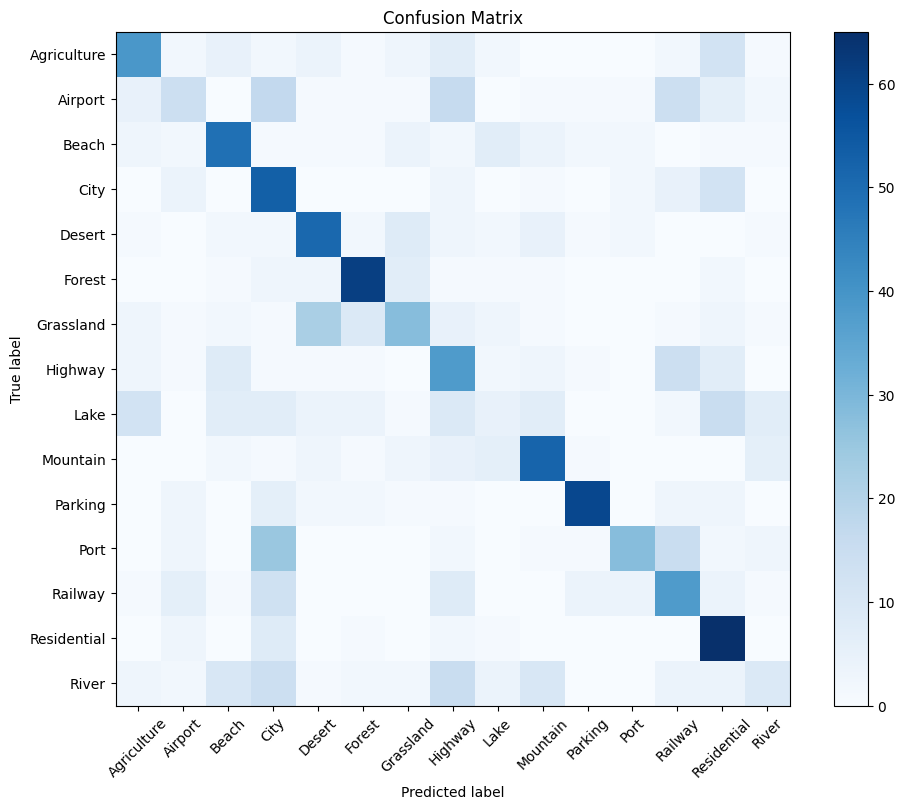

In [ ]:
y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (overfitting measure): {train_accuracy - test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')